In [1]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import h5py

In [2]:
train = pd.read_csv('train.csv')
train.head()
index=train.columns[2:]
print(index)

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'N/A', 'News', 'Reality-TV', 'Romance',
       'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')


In [3]:
train.shape

(7254, 27)

In [11]:
image_data = []
for i in range(train.shape[0]):
    try :
        img = tf.keras.preprocessing.image.load_img('Images/'+train['Id'][i]+'.jpg',target_size=(128,128,3))
    except :
        pass
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    image_data.append(img)
X = np.array(image_data)

In [12]:
X.shape

(7254, 128, 128, 3)

In [14]:
np.save('preprocessed_data',X,allow_pickle=True)

In [4]:
X = np.load('preprocessed_data.npy')

In [5]:
y = np.array(train.drop(['Id', 'Genre'],axis=1))
y.shape

(7254, 25)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [19]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=16, 
                                kernel_size=(3, 3),
                                activation='relu',
                                input_shape=(128, 128, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(filters=32, 
                                kernel_size=(3, 3),
                                activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(filters=64, 
                                kernel_size=(3, 3),
                                activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(filters=64, 
                                kernel_size=(3, 3),
                                activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, 
                               activation = 'relu'))
model.add(tf.keras.layers.Dense(128, 
                               activation='relu'))
model.add(tf.keras.layers.Dense(25,
                               activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)       

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=128)

Train on 6528 samples, validate on 726 samples
Epoch 1/20
6528/6528 [==============================] - 41s 6ms/sample - loss: 0.2887 - accuracy: 0.8883 - val_loss: 0.3298 - val_accuracy: 0.9068
Epoch 2/20
6528/6528 [==============================] - 39s 6ms/sample - loss: 0.2435 - accuracy: 0.9074 - val_loss: 0.3259 - val_accuracy: 0.9090
Epoch 3/20
6528/6528 [==============================] - 41s 6ms/sample - loss: 0.2394 - accuracy: 0.9098 - val_loss: 0.2861 - val_accuracy: 0.9096
Epoch 4/20
6528/6528 [==============================] - 41s 6ms/sample - loss: 0.2375 - accuracy: 0.9107 - val_loss: 0.2933 - val_accuracy: 0.9082
Epoch 5/20
6528/6528 [==============================] - 41s 6ms/sample - loss: 0.2352 - accuracy: 0.9118 - val_loss: 0.2853 - val_accuracy: 0.9083
Epoch 6/20
6528/6528 [==============================] - 39s 6ms/sample - loss: 0.2355 - accuracy: 0.9114 - val_loss: 0.2785 - val_accuracy: 0.9093
Epoch 7/20
6528/6528 [==============================] - 41s 6ms/sample 

In [22]:
def get_genre(path) :
    img = tf.keras.preprocessing.image.load_img(path,target_size=(128,128,3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    classes = np.array(train.columns[2:])
    proba = model.predict(img.reshape(1,128,128,3))
    most_probable = np.argsort(proba[0])[:-4:-1]
    for i in range(3):
        print("{}".format(classes[most_probable[i]])+" ({:.3})".format(proba[0][most_probable[i]]))
    plt.axis('off')
    plt.imshow(img)

Comedy (0.566)
Drama (0.471)
Romance (0.255)


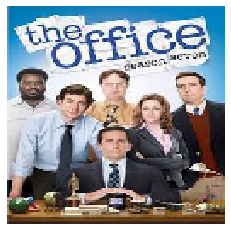

In [23]:
get_genre('the_office.jpg')

Drama (0.634)
Thriller (0.332)
Action (0.251)


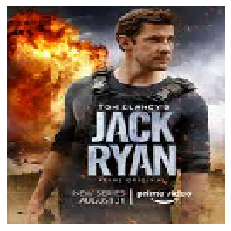

In [28]:
get_genre('jack_ryan.jpg')

In [29]:
model_json = model.to_json()
with open("movie_genre.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("movie_genre.h5")